# Figure 4

**Description:** Distribution and characteristics of putative polyA sites across the genome.

&rarr; Run this notebook with the `tf-train` kernel


In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%run -i notebook_setup.py

Using TensorFlow backend.


## IMPORTS AND SETUP

In [4]:
PROJECT = "/projects/b1080/eks/polyadenylation"
DATADIR = os.path.join(PROJECT, "manuscripts", "01_development", "data")
RESDIR  = os.path.join(PROJECT, "manuscripts", "01_development", "analysis", "resources")
OUTDIR  = os.path.join(PROJECT, "manuscripts", "01_development", "figures", "Figure_04")

os.makedirs(OUTDIR, exist_ok = True)
os.makedirs(os.path.join(os.path.dirname(RESDIR), 'site_density'), exist_ok = True)


## IMPORT DATA

In [5]:
included_features = ['intron:composite','intron:skipped','upstream_exon','terminal_exon','extended_terminal_exon']

try:
    with open(os.path.join(RESDIR, 'putative_sites.pickle'), mode = 'rb') as handle:
        putative_sites = pickle.load(handle)
        
except FileNotFoundError:
    
    putative_sites = pd.read_csv(os.path.join(RESDIR, "putative_cleavage_sites.annotated.with_predictions.txt"), sep = "\t")
    putative_sites = putative_sites.loc[putative_sites['feature'].isin(included_features)].copy()

    with open(os.path.join(RESDIR, 'putative_sites.pickle'), mode = 'wb') as handle:
        pickle.dump(putative_sites, handle)

print(f"Putative sites: {len(putative_sites)}")
print(f"Putative genes: {putative_sites['gene'].nunique()} ({len(putative_sites) / putative_sites['gene'].nunique():.03f})")


Putative sites: 4133468
Putative genes: 30760 (134.378)


## Analyzing the distribution of genome-wide putative sites

#### Identifying expressed putative sites

In [6]:
putative_sites['cluster_slop_binary'] = (putative_sites['cluster_reads_slop'] >= 10).astype(int)
print(f"Expressed sites: {(putative_sites.cluster_reads_slop >= 10).sum()} ({(putative_sites.cluster_reads_slop >= 10).sum() / len(putative_sites):.02%})")
print(f"Expressed genes: {putative_sites.loc[putative_sites.cluster_slop_binary == True, 'gene'].nunique()} ({(putative_sites.cluster_reads_slop >= 10).sum() / putative_sites.loc[putative_sites.cluster_slop_binary == True, 'gene'].nunique():.03f})")


Expressed sites: 115650 (2.80%)
Expressed genes: 21400 (5.404)


#### Number of putative sites per feature

In [7]:
putative_sites_per_feature = (putative_sites['feature'].value_counts()
                              .loc[included_features]
                              .reset_index().rename(columns = {'index' : 'feature', 'feature' : 'count'})
                             )

putative_sites_per_feature['count_log10'] = np.log10(putative_sites_per_feature['count'])
putative_sites_per_feature['prop'] = putative_sites_per_feature['count'] / putative_sites_per_feature['count'].sum()
putative_sites_per_feature['label'] = putative_sites_per_feature['feature'] + " (" + (putative_sites_per_feature['prop']*100).round(2).astype(str) + "%)"


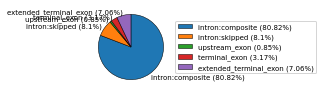

Corresponding data:


,feature,count,count_log10,prop,label
0,intron:composite,3340727,6.523841,0.808214,intron:composite (80.82%)
1,intron:skipped,334919,5.524940,0.081026,intron:skipped (8.1%)
2,upstream_exon,35092,4.545208,0.008490,upstream_exon (0.85%)
3,terminal_exon,130944,5.117086,0.031679,terminal_exon (3.17%)
4,extended_terminal_exon,291786,5.465064,0.070591,extended_terminal_exon (7.06%)


In [8]:
fig,ax = plt.subplots(1,1, figsize = (1.5,1.5))

wedges, texts = plt.pie(putative_sites_per_feature['prop'], 
                        labels = putative_sites_per_feature['label'],
                        startangle = 90, counterclock = False,
                        wedgeprops = {'linewidth' : 0.5, 'edgecolor' : 'black'}
                       )

ax.legend(wedges, putative_sites_per_feature['label'],
          title="",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.savefig(os.path.join(OUTDIR, 'percent_sites_in_feature.pie.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


print("Corresponding data:")
putative_sites_per_feature


#### Number of expressed sites per feature

In [9]:
putative_sites_percent_expressed_by_feature = (putative_sites
                                               .groupby(['feature','cluster_slop_binary']).size()
                                               .loc[included_features]
                                               .reset_index().rename(columns = {0 : 'count'})
                                              )

putative_sites_percent_expressed_by_feature = putative_sites_percent_expressed_by_feature.loc[putative_sites_percent_expressed_by_feature['cluster_slop_binary'] == 1]
putative_sites_percent_expressed_by_feature['prop'] = putative_sites_percent_expressed_by_feature['count'] / putative_sites_percent_expressed_by_feature['count'].sum()
putative_sites_percent_expressed_by_feature['label'] = putative_sites_percent_expressed_by_feature['feature'] + " (" + (putative_sites_percent_expressed_by_feature['prop']*100).round(2).astype(str) + "%)"

putative_sites_percent_expressed_by_feature = putative_sites_percent_expressed_by_feature.set_index('feature').loc[putative_sites_per_feature['feature']]


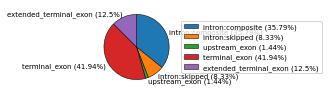

In [10]:
fig,ax = plt.subplots(1,1, figsize = (1.5,1.5))

wedges, texts = plt.pie(putative_sites_percent_expressed_by_feature['prop'], 
                        labels = putative_sites_percent_expressed_by_feature['label'],
                        startangle = 90, counterclock = False,
                        wedgeprops = {'linewidth' : 0.5, 'edgecolor' : 'black'}
                       )

ax.legend(wedges, putative_sites_percent_expressed_by_feature['label'],
          title="",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.savefig(os.path.join(OUTDIR, 'percent_sites_expressed_in_feature.pie.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


#### Data summary

In [11]:
putative_sites_per_feature['category'] = 'putative_sites'
putative_sites_percent_expressed_by_feature['category'] = 'expressed_sites'

putative_sites_comb = (pd.concat([putative_sites_per_feature.reset_index()[['category','feature','prop']],
                                 putative_sites_percent_expressed_by_feature.reset_index()[['category','feature','prop']]
                                ], ignore_index = True, sort = False)
                      )

putative_sites_comb

,category,feature,prop
0,putative_sites,intron:composite,0.808214
1,putative_sites,intron:skipped,0.081026
2,putative_sites,upstream_exon,0.008490
3,putative_sites,terminal_exon,0.031679
4,putative_sites,extended_terminal_exon,0.070591
5,expressed_sites,intron:composite,0.357933
6,expressed_sites,intron:skipped,0.083320
7,expressed_sites,upstream_exon,0.014431
8,expressed_sites,terminal_exon,0.419351
9,expressed_sites,extended_terminal_exon,0.124963


## Visualize fraction of putative sites expressed

In [12]:
def calculate_percent_expressed_absolute(putative_sites, cutoff_var, cutoff_val):
    
    putative_sites_percent_expressed_absolute = (putative_sites
                                                 .loc[putative_sites[cutoff_var] > cutoff_val]
                                                 .groupby(['feature','cluster_slop_binary']).size()
                                                 .loc[included_features]
                                                 .reset_index().rename(columns = {0 : 'count'})
                                                  )

    putative_sites_percent_expressed_absolute['prop'] = putative_sites_percent_expressed_absolute['count'] / putative_sites_percent_expressed_absolute.groupby('feature')['count'].transform('sum')
    putative_sites_percent_expressed_absolute = putative_sites_percent_expressed_absolute.loc[putative_sites_percent_expressed_absolute['cluster_slop_binary'] == 1]
    putative_sites_percent_expressed_absolute['label'] = putative_sites_percent_expressed_absolute['feature'] + " (" + (putative_sites_percent_expressed_absolute['prop']*100).round(2).astype(str) + "%)"
    putative_sites_percent_expressed_absolute = putative_sites_percent_expressed_absolute.set_index('feature').loc[putative_sites_per_feature['feature']]

    return putative_sites_percent_expressed_absolute

putative_exp_abs_orig      = calculate_percent_expressed_absolute(putative_sites, 'classification', 0.5)
putative_exp_abs_stringent = calculate_percent_expressed_absolute(putative_sites, 'classification', 0.95)
putative_exp_abs_super     = calculate_percent_expressed_absolute(putative_sites, 'classification', 0.99)
putative_exp_abs_strength  = calculate_percent_expressed_absolute(putative_sites, 'strength', 0)

putative_exp_abs_orig['category']      = 'polyaID > 0.5'
putative_exp_abs_stringent['category'] = 'polyaID > 0.95'
putative_exp_abs_super['category']     = 'polyaID > 0.99'
putative_exp_abs_strength['category']  = 'polyaStrength > 0'


#### Using PolyaID > 0.5

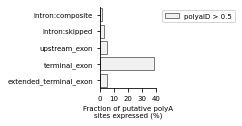

Corresponding data:
                  feature  cluster_slop_binary  count       prop  \
0        intron:composite                    1  40656   1.313821   
1          intron:skipped                    1   9440   3.031675   
2           upstream_exon                    1   1616   5.035052   
3           terminal_exon                    1  47183  38.512962   
4  extended_terminal_exon                    1  14104   5.197294   

                           label       category  
0       intron:composite (1.31%)  polyaID > 0.5  
1         intron:skipped (3.03%)  polyaID > 0.5  
2          upstream_exon (5.04%)  polyaID > 0.5  
3         terminal_exon (38.51%)  polyaID > 0.5  
4  extended_terminal_exon (5.2%)  polyaID > 0.5  


In [13]:
fig,ax = plt.subplots(1,1, figsize = (1,1.5))

putative_exp_abs = pd.concat([
    putative_exp_abs_orig.reset_index(),
], ignore_index = True, sort = False)

putative_exp_abs['prop'] = putative_exp_abs['prop'] * 100

sns.barplot(data = putative_exp_abs, 
            x = 'prop', y = 'feature', hue = 'category',
            order = included_features,
            color = 'gray', edgecolor = 'black', linewidth = 0.5, ax = ax
           )

ax.set_xlim(0,40)
ax.xaxis.set_major_locator(MultipleLocator(10))

ax.set_xlabel("Fraction of putative polyA\nsites expressed (%)")
ax.set_ylabel("")

ax.legend(bbox_to_anchor = (1.05,1))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, f'poster_figure.percent_expressed_sites.vertical.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


print("Corresponding data:")
print(putative_exp_abs)


#### By PolyaID cutoff

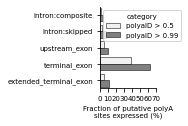

In [14]:
fig,ax = plt.subplots(1,1, figsize = (1,1.5))

putative_exp_abs = pd.concat([
    putative_exp_abs_orig.reset_index(),
    putative_exp_abs_super.reset_index(),
], ignore_index = True, sort = False)

putative_exp_abs['prop'] = putative_exp_abs['prop'] * 100

sns.barplot(data = putative_exp_abs, 
            x = 'prop', y = 'feature', hue = 'category',
            order = included_features,
            color = 'gray', edgecolor = 'black', linewidth = 0.5, ax = ax
           )

ax.set_xlim(0,70)
ax.xaxis.set_major_locator(MultipleLocator(10))

ax.set_xlabel("Fraction of putative polyA\nsites expressed (%)")
ax.set_ylabel("")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, f'05.main_figure.percent_expressed_sites.scale.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


### Expressed Putative Site Usage by Feature

In [15]:
gene_counts = putative_sites['gene'].value_counts()
gene_multiples = gene_counts[gene_counts >= 2].index
print(len(gene_multiples))


30561


In [16]:
putative_exp = putative_sites.loc[putative_sites['gene'].isin(gene_multiples) & (putative_sites['cluster_slop_binary'] == True) & (putative_sites['feature'].isin(included_features))]
print(putative_exp.shape)
print(putative_exp['feature'].value_counts())


(115543, 39)
terminal_exon             48411
intron:composite          41391
extended_terminal_exon    14438
intron:skipped             9636
upstream_exon              1667
Name: feature, dtype: int64


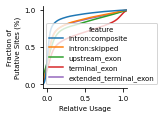

In [17]:
fig,ax = plt.subplots(1,1, figsize = (1.5, 1.5))

sns.kdeplot(data = putative_exp, 
            x = 'cluster_slop_score_denom', hue = 'feature', 
            hue_order = included_features,
            cumulative = True, common_norm = False, common_grid = False,
            ax = ax
           )

ax.set_xlim(-0.05,1.05)
ax.xaxis.set_major_locator(MultipleLocator(0.5))

ax.set_ylim(-0.05,1.05)
ax.yaxis.set_major_locator(MultipleLocator(0.5))

ax.set_xlabel("Relative Usage")
ax.set_ylabel("Fraction of\nPutative Sites (%)")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, f'05.supp.usage_by_feature.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


### Site Count and Density

#### Expression definition: 3'READS >= 10

In [18]:
convert_feature = {
    'terminal_exon' : 'TerminalExonic',
    'extended_terminal_exon' : 'ExtendedTerminalExonic',
    'intron:composite' : 'CompositeIntronic',
    'intron:skipped' : 'SkippedIntronic',
    'upstream_exon' : 'UpstreamExonic',
}

putative_sites['new_score'] = int(1)

putative_sites['new_feature'] = putative_sites['feature'].apply(lambda x : convert_feature[x])
print(putative_sites['new_feature'].value_counts())

putative_sites['new_label'] = "PolyaIDclassification_" + putative_sites['classification'].round(3).astype(str)
putative_sites['new_label'] = putative_sites['new_label'] + "|PolyaStrength_" + putative_sites['strength'].round(3).astype(str)
putative_sites['new_label'] = putative_sites['new_label'] + "|" + putative_sites['gene']
putative_sites['new_label'] = putative_sites['new_label'] + "," + putative_sites['new_feature']

bed_cols = ['chrom', 'start', 'end', 'new_label', 'new_score', 'strand']

for s in ['+','-']:
    (putative_sites.loc[(putative_sites['strand'] == s), bed_cols]
     .to_csv(os.path.join(os.path.dirname(RESDIR), 'site_density', f'putative_sites.{s}.bed'), sep = "\t", index = False, header = False))


CompositeIntronic         3340727
SkippedIntronic            334919
ExtendedTerminalExonic     291786
TerminalExonic             130944
UpstreamExonic              35092
Name: new_feature, dtype: int64


/home/esk863/.local/lib/python3.6/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [19]:
putative_sites['new_label'] = putative_sites['gene'] + "|" + putative_sites['feature']
putative_sites['new_label'] = putative_sites['new_label'] + "|polyaIDclassification_" + putative_sites['classification'].round(3).astype(str)
putative_sites['new_label'] = putative_sites['new_label'] + "|polyaIDcleavageprofile_" + putative_sites['score'].round(3).astype(str)

putative_sites['new_label'] = putative_sites['new_label'] + "|reads_" + putative_sites['cluster_reads_slop'].astype(str)
putative_sites['new_label'] = putative_sites['new_label'] + "|ru_" + putative_sites['cluster_slop_score_denom'].round(3).astype(str)

putative_sites['new_score'] = int(1)

expressed_sites = putative_sites.loc[putative_sites['cluster_slop_binary'] == 1].copy()

bed_cols      = ['chrom', 'start', 'end', 'new_label', 'new_score', 'strand']
bedgraph_cols = ['chrom', 'start', 'end', 'cluster_binprob']

for s in ['+','-']:
    
    (putative_sites.loc[(putative_sites['strand'] == s), bed_cols]
     .to_csv(os.path.join(os.path.dirname(RESDIR), 'site_density', f'putative_sites.{s}.bed'), sep = "\t", index = False, header = False))
    
    (putative_sites.loc[(putative_sites['strand'] == s), bedgraph_cols]
     .to_csv(os.path.join(os.path.dirname(RESDIR), 'site_density', f'putative_sites.{s}.bedgraph'), sep = "\t", index = False, header = False))
             
    (expressed_sites.loc[(expressed_sites['strand'] == s), bed_cols]
     .to_csv(os.path.join(os.path.dirname(RESDIR), 'site_density', f'expressed_sites.{s}.bed'), sep = "\t", index = False, header = False))
    
    (expressed_sites.loc[(expressed_sites['strand'] == s), bedgraph_cols]
     .to_csv(os.path.join(os.path.dirname(RESDIR), 'site_density', f'expressed_sites.{s}.bedgraph'), sep = "\t", index = False, header = False))
    
for f in included_features:
    
    (putative_sites.loc[(putative_sites['feature'] == f), bed_cols]
     .to_csv(os.path.join(os.path.dirname(RESDIR), 'site_density', f'putative_sites.{f.replace(":","_")}.bed'), sep = "\t", index = False, header = False))
             
    (expressed_sites.loc[(expressed_sites['feature'] == f), bed_cols]
     .to_csv(os.path.join(os.path.dirname(RESDIR), 'site_density', f'expressed_sites.{f.replace(":","_")}.bed'), sep = "\t", index = False, header = False))


#### Summarize sites per gene

In [20]:
print("# unique putative sites:\t\t", len(putative_sites))
print("# unique genes with putative sites:\t", putative_sites['gene'].nunique())
print("# putative sites per gene overall:\t", len(putative_sites) / putative_sites['gene'].nunique())

print("\n# unique expressed sites:\t\t", len(expressed_sites))
print("# unique genes with expressed sites:\t", expressed_sites['gene'].nunique())
print("# expressed sites per gene overall:\t", len(expressed_sites) / expressed_sites['gene'].nunique())


# unique putative sites:		 4133468
# unique genes with putative sites:	 30760
# putative sites per gene overall:	 134.3780234070221

# unique expressed sites:		 115650
# unique genes with expressed sites:	 21400
# expressed sites per gene overall:	 5.404205607476635


In [21]:
for f in included_features:
    print(f'\n#####\n{f}')
    
    putative_sites_f = putative_sites.loc[putative_sites['feature'] == f]
    expressed_sites_f = expressed_sites.loc[expressed_sites['feature'] == f]
    
    print("# unique putative sites:\t\t", len(putative_sites_f))
    print("# unique genes with putative sites:\t", putative_sites_f['gene'].nunique())
    print("# putative sites per gene overall:\t", len(putative_sites_f) / putative_sites_f['gene'].nunique())

    print("\n# unique expressed sites:\t\t", len(expressed_sites_f))
    print("# unique genes with expressed sites:\t", expressed_sites_f['gene'].nunique())
    print("# expressed sites per gene overall:\t", len(expressed_sites_f) / expressed_sites_f['gene'].nunique())
    


#####
intron:composite
# unique putative sites:		 3340727
# unique genes with putative sites:	 27533
# putative sites per gene overall:	 121.33537936294628

# unique expressed sites:		 41395
# unique genes with expressed sites:	 12022
# expressed sites per gene overall:	 3.4432706704375313

#####
intron:skipped
# unique putative sites:		 334919
# unique genes with putative sites:	 7876
# putative sites per gene overall:	 42.5239969527679

# unique expressed sites:		 9636
# unique genes with expressed sites:	 3099
# expressed sites per gene overall:	 3.1093901258470473

#####
upstream_exon
# unique putative sites:		 35092
# unique genes with putative sites:	 13007
# putative sites per gene overall:	 2.697931882832321

# unique expressed sites:		 1669
# unique genes with expressed sites:	 1271
# expressed sites per gene overall:	 1.3131392604248624

#####
terminal_exon
# unique putative sites:		 130944
# unique genes with putative sites:	 25174
# putative sites per gene overall:	 5.2015

#### Summarize site density

In [22]:
site_counts = {}

for f in included_features:
    site_counts[f] = {'putative' : {}, 'expressed' : {}}

In [23]:
putative_site_counts = putative_sites['feature'].value_counts().to_dict()
print(putative_site_counts)

for f in included_features: site_counts[f]['putative']['num_sites'] = putative_site_counts[f]


{'intron:composite': 3340727, 'intron:skipped': 334919, 'extended_terminal_exon': 291786, 'terminal_exon': 130944, 'upstream_exon': 35092}


In [24]:
putative_site_genes = putative_sites.groupby('feature')['gene'].nunique().loc[included_features].to_dict()
print(putative_site_genes)

for f in included_features: site_counts[f]['putative']['num_genes'] = putative_site_genes[f]


{'intron:composite': 27533, 'intron:skipped': 7876, 'upstream_exon': 13007, 'terminal_exon': 25174, 'extended_terminal_exon': 29034}


In [25]:
expressed_site_counts = expressed_sites['feature'].value_counts().to_dict()
print(expressed_site_counts)

for f in included_features: site_counts[f]['expressed']['num_sites'] = expressed_site_counts[f]


{'terminal_exon': 48498, 'intron:composite': 41395, 'extended_terminal_exon': 14452, 'intron:skipped': 9636, 'upstream_exon': 1669}


In [26]:
expressed_site_genes = expressed_sites.groupby('feature')['gene'].nunique().loc[included_features].to_dict()
print(expressed_site_genes)

for f in included_features: site_counts[f]['expressed']['num_genes'] = expressed_site_genes[f]


{'intron:composite': 12022, 'intron:skipped': 3099, 'upstream_exon': 1271, 'terminal_exon': 17441, 'extended_terminal_exon': 8996}


In [27]:
print("feature\t\t\tputative_bases\texpressed_bases")

for f in included_features:
    
    fsum_put = 0
    fsum_exp = 0
    
    fput_list = glob.glob(os.path.join(os.path.dirname(RESDIR), 'site_density', f'putative_sites.' + f.replace(":","_") + '.overlapping_*.merged.bed'))[0]
    fexp_list = glob.glob(os.path.join(os.path.dirname(RESDIR), 'site_density', f'expressed_sites.' + f.replace(":","_") + '.overlapping_*.merged.bed'))[0]

    with open(fput_list, mode = 'r') as handle:
        for line in handle:
            llist = line.strip().split("\t")
            fsum_put += (int(llist[2]) - int(llist[1]))
            
    with open(fexp_list, mode = 'r') as handle:
        for line in handle:
            llist = line.strip().split("\t")
            fsum_exp += (int(llist[2]) - int(llist[1]))
            
    if (len(f) < 16):
        print(f'{f}\t\t{fsum_put}\t{fsum_exp}')
    else:
        print(f'{f}\t{fsum_put}\t{fsum_exp}')
    
    site_counts[f]['putative']['occ_bases'] = fsum_put
    site_counts[f]['expressed']['occ_bases'] = fsum_exp
    

feature			putative_bases	expressed_bases
intron:composite	1177202001	561699664
intron:skipped		339036621	146713355
upstream_exon		13102402	1942178
terminal_exon		52329198	39736505
extended_terminal_exon	155302473	44124706


In [28]:
for f in included_features:
    
    site_counts[f]['putative']['sites_per_gene'] = site_counts[f]['putative']['num_sites'] / site_counts[f]['putative']['num_genes']
    site_counts[f]['putative']['sites_per_1kb']  = site_counts[f]['putative']['num_sites'] / site_counts[f]['putative']['occ_bases'] * 1000
    site_counts[f]['putative']['sites_per_10kb'] = site_counts[f]['putative']['num_sites'] / site_counts[f]['putative']['occ_bases'] * 10000
    
    site_counts[f]['expressed']['sites_per_gene'] = site_counts[f]['expressed']['num_sites'] / site_counts[f]['expressed']['num_genes']
    site_counts[f]['expressed']['sites_per_1kb']  = site_counts[f]['expressed']['num_sites'] / site_counts[f]['expressed']['occ_bases'] * 1000
    site_counts[f]['expressed']['sites_per_10kb'] = site_counts[f]['expressed']['num_sites'] / site_counts[f]['expressed']['occ_bases'] * 10000
    

In [29]:
values = ['num_sites','num_genes','sites_per_gene','occ_bases','sites_per_1kb','sites_per_10kb']

for fkey1,fdict1 in site_counts.items():
    print(f"\n#####\n{fkey1}")
    
    for fkey2,fdict2 in fdict1.items():
        print("\t", fkey2)
        
        for fkey3 in values:
            print(f"\t\t{fkey3}\t{fdict2[fkey3]:.03f}")
    


#####
intron:composite
	 putative
		num_sites	3340727.000
		num_genes	27533.000
		sites_per_gene	121.335
		occ_bases	1177202001.000
		sites_per_1kb	2.838
		sites_per_10kb	28.379
	 expressed
		num_sites	41395.000
		num_genes	12022.000
		sites_per_gene	3.443
		occ_bases	561699664.000
		sites_per_1kb	0.074
		sites_per_10kb	0.737

#####
intron:skipped
	 putative
		num_sites	334919.000
		num_genes	7876.000
		sites_per_gene	42.524
		occ_bases	339036621.000
		sites_per_1kb	0.988
		sites_per_10kb	9.879
	 expressed
		num_sites	9636.000
		num_genes	3099.000
		sites_per_gene	3.109
		occ_bases	146713355.000
		sites_per_1kb	0.066
		sites_per_10kb	0.657

#####
upstream_exon
	 putative
		num_sites	35092.000
		num_genes	13007.000
		sites_per_gene	2.698
		occ_bases	13102402.000
		sites_per_1kb	2.678
		sites_per_10kb	26.783
	 expressed
		num_sites	1669.000
		num_genes	1271.000
		sites_per_gene	1.313
		occ_bases	1942178.000
		sites_per_1kb	0.859
		sites_per_10kb	8.593

#####
terminal_exon
	 putative
		n

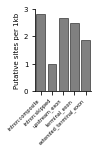

In [30]:
fig,ax = plt.subplots(1,1, figsize = (1,1.5))

# yvar = 'sites_per_gene'
yvar = 'sites_per_1kb'
# yvar = 'sites_per_10kb'

yfilt = 'putative'
# yfilt = 'expressed'

ys = [site_counts[f][yfilt][yvar] for f in included_features]

sns.barplot(x = included_features, y = ys,
            order = included_features,
            color = 'gray', edgecolor = 'black',
            linewidth = 0.5, ax = ax
           )

ax.set_xticklabels(included_features, rotation = 45, ha = 'right', fontsize = 5)

ax.set_ylim(0,3)
ax.yaxis.set_major_locator(MultipleLocator(1))

# ax.set_xlabel("Fraction of Putative PolyA\nSites Expressed (%)")
ax.set_ylabel(f'{yfilt.capitalize()} {yvar.replace("_", " ")}')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, f'site_density.{yfilt}.{yvar}.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()

